<a href="https://colab.research.google.com/github/yeolives/Dacon_AIfriends/blob/master/AIfriends_temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 공공 데이터 활용 온도 추정 AI 경진대회
### LightGBM + XGBoost Ensemble을 이용한 온도 예측 
---
- [데이콘](https://dacon.io/competitions/official/235584/overview/) 에서 주관한 대회
- 분석 및 모델 : [WooYeol Shim](https://github.com/yeolives), [Hyunyong Park](https://github.com/hyunyongPark)
- 총 373팀 중 35등 (상위 10% 이내) 달성
----


본 대회는 target attribute를 총 19개가 있습니다.
대전 지역에서 측정한 실내외 19곳의 센서데이터와, 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공합니다.
각 장소들의 센서 데이터는 Y00~Y18 이라는 이름으로 데이터에 저장됐습니다.

변수설명
* X00 | X07 | X28 | X31 | X32  : 기온
* X01 | X06 | X22 | X27 | X29  : 현지기압
* X02 | X03 | X18 | X24 | X26  : 풍속
* X04 | X10 | X21 | X36 | X39  : 일일 누적강수량
* X05 | X08 | X09 | X23 | X33  : 해면기압
* X11 | X14 | X16 | X19 | X34  : 일일 누적일사량
* X12 | X20 | X30 | X37 | X38  : 습도
* X13 | X15 | X17 | X25 | X35  : 풍향



* Y00 ~ Y17 : 온도측정 센서기
* Y18 : 예측해야할 온도측정센서기 (최종 target) 

#### 1. 데이터 로드

In [ ]:
import os
os.chdir('C:/Users/etotm/Desktop/dacon_ai')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc, style, font_manager
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')
import pandas.plotting
%matplotlib auto


from sklearn.preprocessing import LabelEncoder


#modeling import
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

Using matplotlib backend: Qt5Agg


In [ ]:
#file load
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv("data/sample_submission.csv")

In [ ]:
print("train shape :", train.shape,"/test shape :",test.shape,"/submission shape :", sub.shape)

train shape : (4752, 60) /test shape : (11520, 41) /submission shape : (11520, 2)


#### 2.EDA

In [ ]:
train.head(3)

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN


In [ ]:
test.head(3)

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,4752,18.7,987.4,1.5,1.3,0.0,1006.8,987.7,21.1,1007.5,...,91.4,17.5,19.2,1007.6,0.0,194.7,0.0,84.0,59.9,0.0
1,4753,18.8,987.4,1.1,1.2,0.0,1006.7,987.7,21.2,1007.5,...,91.6,17.4,19.1,1007.5,0.0,173.1,0.0,84.0,60.5,0.0
2,4754,19.0,987.4,1.3,1.2,0.0,1006.6,987.6,21.2,1007.4,...,92.0,17.2,19.0,1007.5,0.0,208.6,0.0,85.0,60.8,0.0


In [ ]:
train.describe()

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
count,4752.00000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,...,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,432.000000
mean,2375.50000,20.227904,988.621107,1.509764,1.453157,1.270223,1008.333902,989.005093,21.658081,1008.790341,...,22.222801,23.737269,24.649653,23.641898,20.926157,21.319444,21.564468,22.969097,23.381829,26.687500
std,1371.92857,4.707570,3.359916,1.071858,0.936151,4.429852,3.395037,3.403714,4.377216,3.520317,...,9.112299,10.599000,12.214870,8.400081,6.106031,7.066149,6.810084,8.054272,9.275172,6.286621
min,0.00000,8.300000,977.300000,0.000000,0.000000,0.000000,997.200000,978.100000,11.600000,997.300000,...,3.500000,4.000000,3.000000,6.000000,7.500000,7.500000,7.000000,6.000000,7.000000,18.500000
25%,1187.75000,16.900000,986.800000,0.700000,0.800000,0.000000,1006.500000,987.100000,18.400000,1006.700000,...,15.500000,15.500000,15.000000,17.000000,16.500000,16.500000,16.500000,16.500000,16.000000,21.000000
50%,2375.50000,19.900000,988.600000,1.300000,1.300000,0.000000,1008.500000,989.100000,21.200000,1008.800000,...,20.000000,20.500000,21.000000,22.000000,19.500000,19.500000,20.000000,21.500000,20.000000,25.000000
75%,3563.25000,24.100000,991.000000,2.100000,2.000000,0.000000,1010.800000,991.600000,24.825000,1011.400000,...,30.500000,32.500000,34.500000,30.500000,25.000000,25.000000,27.000000,30.000000,32.000000,31.500000
max,4751.00000,30.900000,997.200000,10.200000,5.800000,25.600000,1016.800000,997.400000,32.700000,1017.500000,...,42.000000,49.000000,53.000000,43.500000,38.000000,42.500000,40.500000,41.500000,43.500000,41.500000


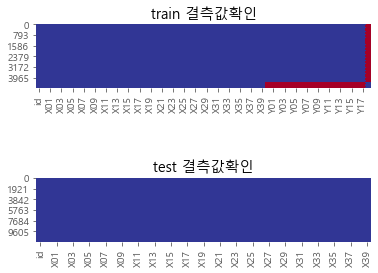

In [ ]:
%matplotlib inline
plt.subplot(311); sns.heatmap(train.isnull(), cbar=False, cmap = plt.cm.RdYlBu_r) ; plt.title('train 결측값확인')
plt.subplot(313); sns.heatmap(test.isnull(), cbar=False, cmap = plt.cm.RdYlBu_r) ; plt.title('test 결측값확인')
plt.show()

---
* Y00~Y17 : 30일간 결측, 이후 3일은 기록
* Y18 : 30일간 기록, 이후 3일 결측
---

센서기에 대한 분포를 살펴보면 다음과 같다.

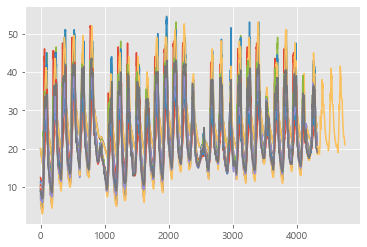

In [ ]:
target = ['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08','Y09', 'Y10', \
          'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18']
train[target].head()
plt.plot(train.loc[:, 'Y00':'Y18'])

센서기와 최종 타겟 센서기와의 상관관계를 살펴보면 다음과 같다. 

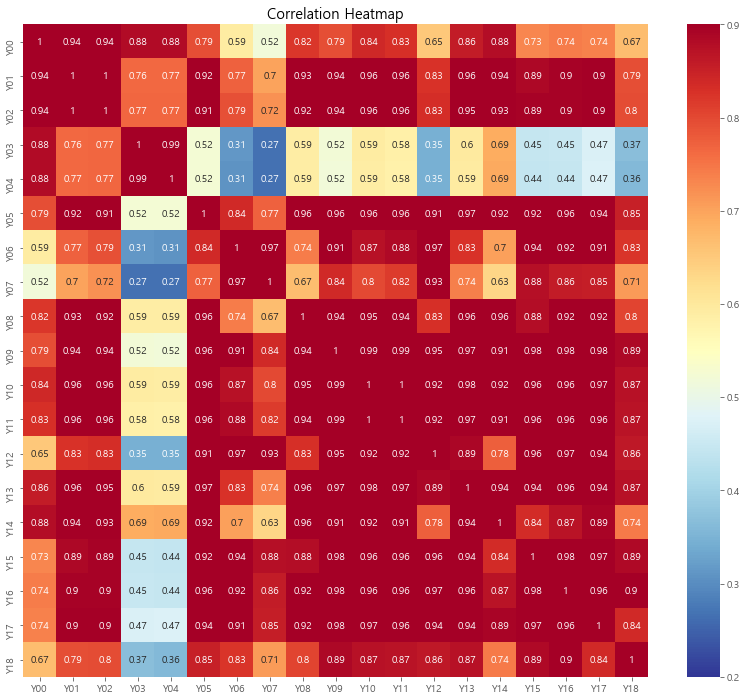

In [ ]:
y18 = train[~train['Y18'].isnull()]['Y18'].reset_index(drop= True)
no_y18_target = ['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08','Y09', 'Y10', \
                 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17']
no_y18 = train[(train['Y18'].isnull()) & (train['id'] > 3887)][no_y18_target].reset_index(drop = True)
check_target = pd.concat([no_y18, y18], axis = 1)

correlations =  check_target.corr()
plt.figure(figsize = (14, 12))
sns.heatmap(correlations, cmap = plt.cm.RdYlBu_r,  vmin = 0.2, annot = True, vmax = 0.9)
plt.title('Correlation Heatmap');

파란부분으로 target과의 상관관계가 매우 낮게 측정되는 Y03과 Y04가 의심이든다. 

그래프로 이 관계를 자세히 살펴본다.

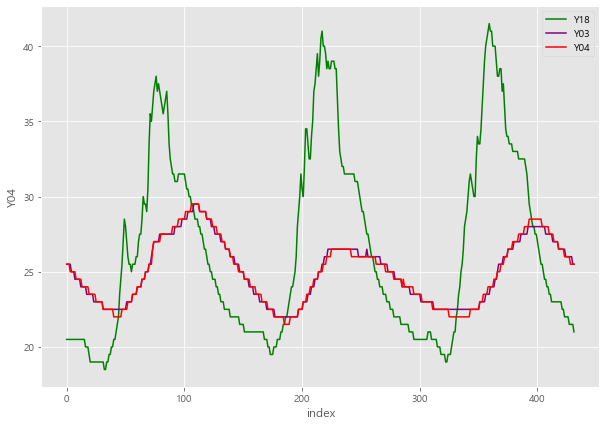

In [ ]:
check_target.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(data=check_target, x='index', y='Y18', color='green', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y03', color='purple', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y04', color='red', ax=ax)
plt.legend(['Y18', 'Y03', 'Y04'])
plt.show()

Y18과는 매우 다른 분포의 범위와 개형을 보인다. 이는 실내에서 측정된 센서기로 추정을 할 수 있다.

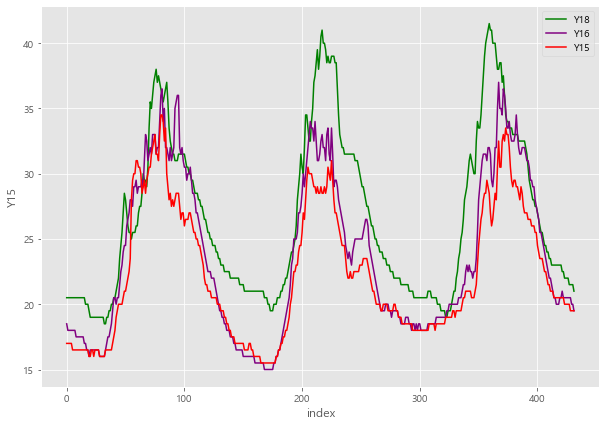

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(data=check_target, x='index', y='Y18', color='green', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y16', color='purple', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y15', color='red', ax=ax)
plt.legend(['Y18', 'Y16', 'Y15'])
plt.show()

상관관계가 가장 좋은 Y15, Y16은 Y18과 매우 근사한 범위와 개형을 보이고 있다.


-------------------------------------------------------------------------------

이번에는 X변수들에 대해서 살펴보자.

In [ ]:
train[['X14', 'X16', 'X19']].describe()

,X14,X16,X19
count,4752.0,4752.0,4752.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0


모든 통계량 값이 0이다. 따라서 이 세 변수는 제거 할 필요가 있다. (기상 측정기가 고장난 것으로 추정)

Text(0.5, 1, 'Correlation Heatmap')

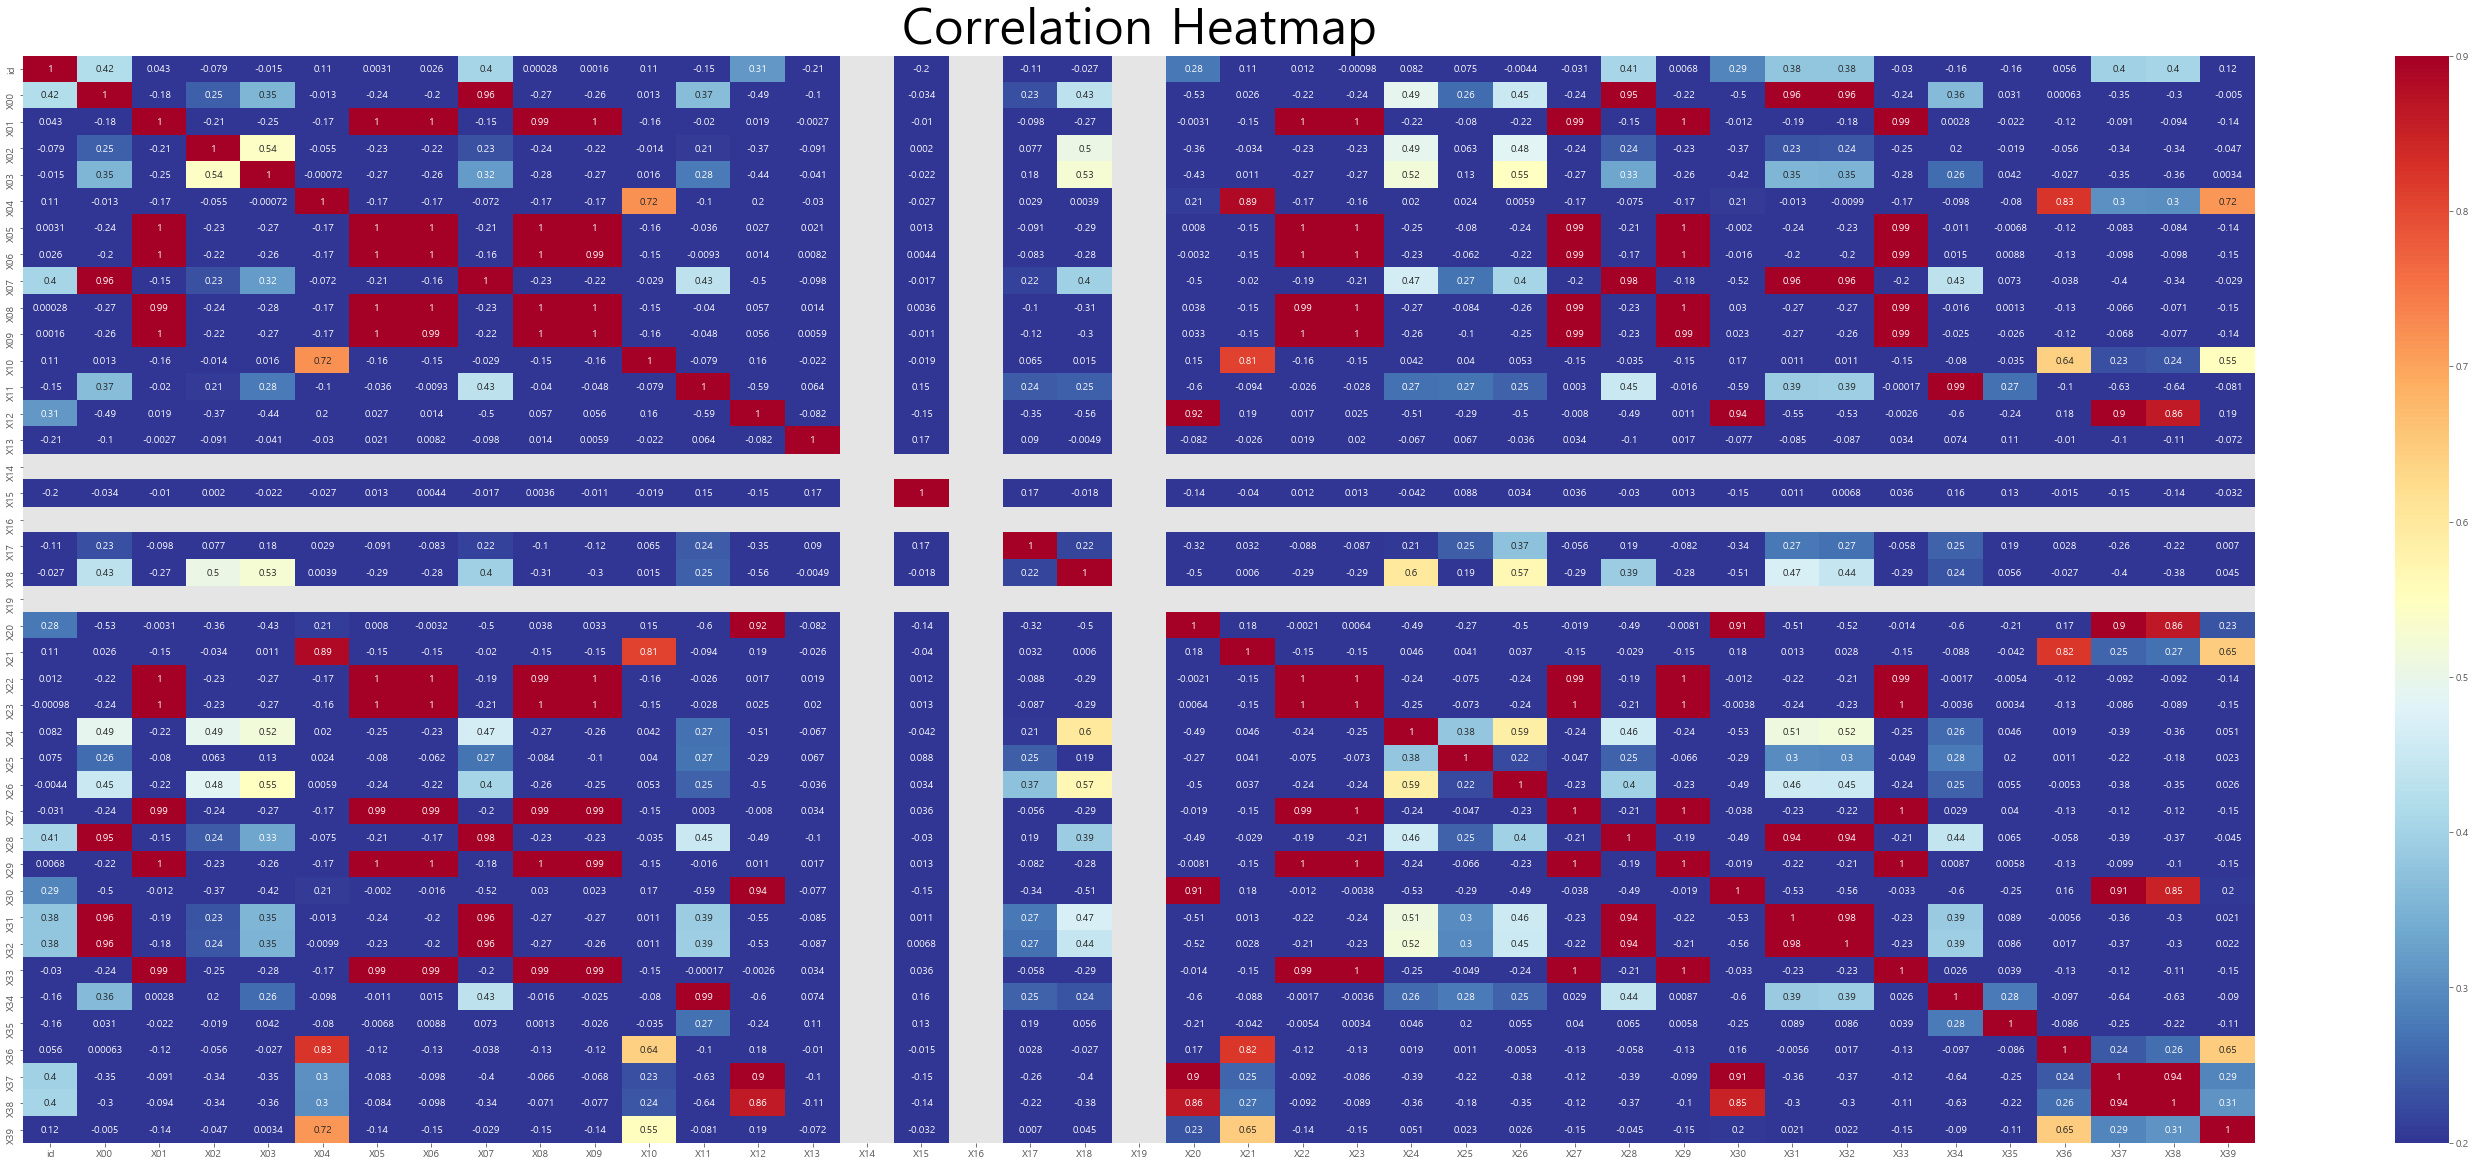

In [ ]:
plt.figure(figsize=(50, 20))

trte_df = train.loc[:,'id':'X39'].append(test)
sns.heatmap(trte_df.corr(), cmap = plt.cm.RdYlBu_r,  vmin = 0.2, annot = True, vmax = 0.9)
plt.title('Correlation Heatmap',fontsize=50)

In [ ]:
def high_corr(tr_X, col, ratio):
    tr_corr = tr_X.corr()
    tr_high = tr_corr.loc[:,tr_corr[col]> ratio].columns
    return tr_high.drop(col) , col

Y_high, col = high_corr(train, "Y18", 0.5)
print(col , "와의 높은 상관의 변수 ", Y_high.tolist())

Y18 와의 높은 상관의 변수  ['X00', 'X07', 'X18', 'X24', 'X28', 'X31', 'X32']


기온변수들인 X00, X07, X28, X31, X32와 풍속변수 X18, X24가 target과의 상관관계가 대체적으로 높은 편이다. 

#### 3.Preprocessing &  Cleansing

In [ ]:
def df_copy(train, test):
    tr = train.copy() ; te = test.copy() # 하위는 참조 /상위는 복사
    return tr, te

#X14, X16, X19 고장
def same_min_max(tr, te):
    tr, te = df_copy(train.loc[:, 'id':'X39'], test)
    for df in [tr, te]:
        df.drop(df.columns[df.max() == df.min()], axis=1, inplace=True)
    return tr , te
tr, te = same_min_max(train, test)
tr.head(3)

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,...,69.1,8.2,10.7,1010.1,0.0,256.4,0.0,77.2,62.6,0.0
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,...,70.3,8.3,10.3,1010.1,0.0,215.4,0.0,77.3,63.5,0.0
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,...,71.5,8.0,9.7,1010.0,0.0,235.2,0.0,77.3,63.9,0.0


누적강수량변수들과 누적일사량변수들을 일일 강수량변수와 일일 일사량변수들로 만들어 추가해준다. 

In [ ]:
#누적 -> 일반
def standardW(tr, te, x_list):
    tr, te = df_copy(tr, te)
    TR = tr.loc[:,x_list]
    TE = te.loc[:,x_list]
    tr2 = pd.DataFrame(index=range(0,TR.shape[0]),columns=x_list)
    te2 = pd.DataFrame(index=range(0,TE.shape[0]),columns=x_list)
    for col in x_list:
        
        for ind in range(TR.shape[0]):
            
            if ind % 144 == 0:
                tr2[col][ind] = TR[col][ind]
            elif ind == 0:
                tr2[col][ind] = TR[col][ind]
            
            else:
                tr2[col][ind] = TR[col][ind] - TR[col][ind-1]
        for indd in range(TE.shape[0]):
            if indd % 144 == 0:
                te2[col][indd] = TE[col][indd]
            elif indd == 0:
                te2[col][indd] = TE[col][indd]    
            else:
                te2[col][indd] = TE[col][indd] - TE[col][indd-1]        

                    
    tr2.columns = tr2.columns.str.replace('X','S')
    te2.columns = te2.columns.str.replace('X','S')
    tr = pd.concat([tr,tr2], axis=1)
    te = pd.concat([te,te2], axis=1)                 
  
    return tr , te

x_list = ["X11","X34"] + ["X04","X10","X21","X36","X39"]
tr, te = standardW(tr, te, x_list)

tr[["S04","S10","S11","S21","S34","S36","S39"]]

,S04,S10,S11,S21,S34,S36,S39
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
4747,0,0,0,0,0,0,0
4748,0,0,0,0,0,0,0
4749,0,0,0,0,0,0,0
4750,0,0,0,0,0,0,0


풍속과 일일강수량의 평균풍속과 평균강수량 변수들을 생성해준다.

In [ ]:
def meaning(tr,te,x_name,x_list):
    tr, te = df_copy(tr,te)
    tr = tr.astype('float')
    te = te.astype('float')
    for i in range(len(x_list)):
        tr[x_name[i]] = tr.loc[:,x_list[i]].mean(axis=1)
        te[x_name[i]] = te.loc[:,x_list[i]].mean(axis=1)
        
    return tr, te       


x_name=['wind_stand']
x_list = [["X02","X03","X18","X24","X26"]]
tr, te = meaning(tr,te,x_name,x_list)

x_name=['rain_stand']
x_list = [["S04","S10","S21","S36","S39"]]
tr, te = meaning(tr,te,x_name,x_list)

tr[['wind_stand', 'rain_stand']]

,wind_stand,rain_stand
0,0.74,0.0
1,0.80,0.0
2,0.80,0.0
3,0.50,0.0
4,0.50,0.0
...,...,...
4747,0.76,0.0
4748,0.70,0.0
4749,0.46,0.0
4750,0.48,0.0


평균풍속에 대해 비온여부에 대한 0,1로 나타내는 변수를 변형해준다.

In [ ]:
def onehot(tr,te, x_list):
    tr, te = df_copy(tr, te)
    for df in [tr, te]:
        for col in x_list:
            for ind in range(len(df)):
                if df[col][ind] == 0:
                    df[col][ind] = 0
                elif df[col][ind] > 0:
                    df[col][ind] = 1
    return tr, te

x_list = [ 'rain_stand']
tr, te = onehot(tr,te,x_list)

해면기압과 현지기압을 통해 표준대기고도라는 변수를 생성할 수 있다.

[표준대기고도](http://magazine.hellot.net/magz/article/articleDetail.do?flag=all&showType=showType1&articleId=ARTI_000000000012022&articleAllListSortType=sort_1&page=1&selectYearMonth=201307&subCtgId=)

In [ ]:
# 표준대기고도
def altitude(tr,te,listd,listd2,col_list):
    tr, te = df_copy(tr, te)
    
    trr = pd.DataFrame(index=range(len(tr)),columns=col_list)
    tee = pd.DataFrame(index=range(len(te)),columns=col_list)
    
    trr.loc[:] = pd.DataFrame(44330.0 * (1.0-(tr.loc[:,listd].values/tr.loc[:,listd2].values)**(1.0/5.225)))
    tee.loc[:] = 44330.0 * (1.0-(te.loc[:,listd].values/te.loc[:,listd2].values)**(1.0/5.225))            
    
    tr = pd.concat([tr,trr],axis=1)
    te = pd.concat([te,tee],axis=1)
    return tr, te 

listd = ["X05","X08","X09","X23","X33"]
listd2 = ["X22","X06","X01","X29","X27"]
col_list = ["alt_05_02","alt_08_06","alt_09_01","alt_23_29","alt_33_27"]
tr, te = altitude(tr,te,listd,listd2,col_list)

tr[["alt_05_02","alt_08_06","alt_09_01","alt_23_29","alt_33_27"]]

,alt_05_02,alt_08_06,alt_09_01,alt_23_29,alt_33_27
0,-57.391579,-172.613656,-178.658839,-69.230608,-11.768846
1,-57.391579,-173.456997,-178.640926,-69.223719,-11.768846
2,-57.397289,-173.439615,-179.466387,-69.230608,-11.770012
3,-57.397289,-173.456997,-179.484381,-69.237498,-11.768846
4,-57.397289,-173.439615,-179.484381,-69.237498,-11.768846
...,...,...,...,...,...
4747,-54.981072,-168.717288,-168.734235,-68.539131,-12.642794
4748,-54.986554,-168.717288,-168.734235,-68.539131,-12.642794
4749,-54.981072,-168.734235,-168.717288,-68.532296,-12.642794
4750,-54.981072,-168.700344,-168.717288,-68.532296,-13.485106


표준대기고도를 평균대기고도로 변형해주고, 기존 표준대기고도열들은 삭제해준다. (빼는 것이 더 성능이 좋았음.)

In [ ]:
tr['mean_alt'] = tr.loc[:,["alt_05_02","alt_08_06","alt_09_01","alt_23_29","alt_33_27"]].mean(axis=1)
te['mean_alt'] = te.loc[:,["alt_05_02","alt_08_06","alt_09_01","alt_23_29","alt_33_27"]].mean(axis=1)

tr.drop(["alt_05_02","alt_08_06","alt_09_01","alt_23_29","alt_33_27"],axis=1,inplace=True)
te.drop(["alt_05_02","alt_08_06","alt_09_01","alt_23_29","alt_33_27"],axis=1,inplace=True)

tr[['mean_alt']]

,mean_alt
0,-97.932706
1,-98.096413
2,-98.260782
3,-98.269002
4,-98.265526
...,...
4747,-94.722904
4748,-94.724000
4749,-94.721537
4750,-94.883221


습도와 기온의 관계를 이용하여 기온대비 습도의 비율값을 생성해준다.

In [ ]:
def ratio(tr,te,listd_corr, listd2_corr, col_list_corr):
    tr, te = df_copy(tr, te)
    ra_tr = pd.DataFrame(index=range(0,len(tr)),columns=col_list_corr)
    ra_te = pd.DataFrame(index=range(0,len(te)),columns=col_list_corr)
    ra_tr.loc[:,col_list_corr[0:5]] = tr.loc[:,listd_corr].values / tr.loc[:,listd2_corr].values
    ra_te.loc[:,col_list_corr[0:5]] = te.loc[:,listd_corr].values / te.loc[:,listd2_corr].values
    
    tr = pd.concat([tr, ra_tr], axis=1)
    te = pd.concat([te, ra_te], axis=1)
    
    return tr, te
 
listd_corr = ['X00',"X07","X28","X31","X32"]
listd2_corr = ["X20","X37","X38","X12","X30"]
col_list_corr = ['X00/X20','X07/X37', 'X28/X38', 'X31/X12','X32/X30']

tr, te = ratio(tr, te , listd_corr, listd2_corr, col_list_corr)

일사량과 기온은 양의관계이다. 일사량을 가중치로하여 기온과의 관계를 형성하는 열을 만들어준다. 

In [ ]:
tr['ilsa*keyon'] = tr.loc[:,["X00","X07","X28","X31","X32"]].mean(axis=1) * tr.loc[:,["S11","S34"]].mean(axis=1) 
te['ilsa*keyon'] = te.loc[:,["X00","X07","X28","X31","X32"]].mean(axis=1) * te.loc[:,["S11","S34"]].mean(axis=1) 

change the standard sun(일사량 변수의 값을 조정) - 이상치를 전시점의 값으로 대체하여 보다 매끄럽게 조정해줌

In [ ]:
def retrans_new(tr, te, x_list):
    tr, te = df_copy(tr, te)
    
    for col in x_list:        
        for ind in range(tr.shape[0]):
            if ind == 0:
                tr[col][ind] = tr[col][ind]        
            elif abs(tr[col][ind] - tr[col][ind-1]) > 0.3:
                tr[col][ind] = tr[col][ind-1]
            else:
                tr[col][ind] = tr[col][ind]
        for ind2 in range(te.shape[0]):
            if ind2 == 0:
                te[col][ind2] = te[col][ind2]        
            elif abs(te[col][ind2] - te[col][ind2-1]) > 0.3:
                te[col][ind2] = te[col][ind2-1]
            else:
                te[col][ind2] = te[col][ind2]
        
    return tr , te

x_list = ['S11','S34']
tr, te = retrans_new(tr,te,x_list)

풍속변수의 이상값을 제거하기 위해 선행적으로 표준화를 실시해준다.

In [ ]:
# 표준화
def standardization(df):
    mean = df.mean()
    std = df.std()
    norm = (df - mean) / (std - 1e-07)
    return norm, mean, std


#std_name = tr[tr.columns.difference(['minute_sin','minute_cos','hour_sin','hour_cos','Mergetime'])].columns.tolist()

std_col = ["X02","X03","X18","X24","X26"] 
# ["X00","X07","X28","X31","X32"]
std_name = tr.loc[:,std_col].columns.tolist()
train_X_norm, mean, std = standardization(tr[std_name])
train_X_norm.columns = train_X_norm.columns.str.replace('X','ZX')
train_X_norm.columns = train_X_norm.columns.str.replace('S','ZS') 
#테스트용 데이터 표준화
test_X_norm = (te[std_name] - mean) / (std - 1e-07)
test_X_norm.columns = test_X_norm.columns.str.replace('X','ZX')
test_X_norm.columns = test_X_norm.columns.str.replace('S','ZS') 
tr = pd.concat([tr,train_X_norm], axis=1)
te = pd.concat([te,test_X_norm], axis=1)

표준화중 +-3 범위를 기준으로 벗어난 이상값 전후 평균값으로 대체를 해준다. 

In [ ]:
#표준화중 +-3 벗어난 outlier 전후 평균값으로 대체
def transe(tr, te, train_X_norm, test_X_norm):            
    tr, te = df_copy(tr,te)
    Trn = train_X_norm ; Ten = test_X_norm
    
    column = Trn.columns.tolist()
    trn = pd.DataFrame(index=range(0,Trn.shape[0]),columns=column)
    ten = pd.DataFrame(index=range(0,Ten.shape[0]),columns=column)
    for col in column:
        for ind in range(len(Trn)):
            if Trn[col][ind]>3 or Trn[col][ind]<-3:
                trn[col][ind] = np.nan 
            else:
                trn[col][ind] = Trn[col][ind]
            
        for ind2 in range(len(Ten)):
            if Ten[col][ind2]>3 or Ten[col][ind2]<-3:
                ten[col][ind2] = np.nan 
            else:
                ten[col][ind2] = Ten[col][ind2]
        trn = trn.astype('float')
        ten = ten.astype('float')            
        tr_norm = trn.interpolate(method='values')
        te_norm = ten.interpolate(method='values')
#    tr = pd.concat([tr, tr_norm], axis=1)
#    te = pd.concat([te, te_norm], axis=1)
    
    return  tr , te, trn, ten

tr, te, trn, ten = transe(tr, te, train_X_norm, test_X_norm)

In [ ]:
def realtranse(tr, te, trn, ten):
    tr, te = df_copy(tr, te)
    
    
    trn.columns = trn.columns.str.replace('ZX','X')
    trn.columns = trn.columns.str.replace('ZS','S')
    ten.columns = ten.columns.str.replace('ZX','X')
    ten.columns = ten.columns.str.replace('ZS','S')
    
    column = trn[:].columns.tolist()

    for col in column:
        for ind in trn.loc[trn.isnull()[col]][col].index.tolist():
            tr[col][ind] = np.nan
            
        for ind in ten.loc[ten.isnull()[col]][col].index.tolist():
            te[col][ind] = np.nan

    tr = tr.astype('float')
    te = te.astype('float')            
    tr = tr.interpolate(method='values')
    te = te.interpolate(method='values')
    
    return tr, te

tr, te = realtranse(tr,te,trn,ten)

10분마다 반복되는 하루의 주기를 삼각함수로 표현한다. 

In [ ]:
#id는 반복되는 시간임. 따라서 -> 시간화시켜서 삼각함수 반복
def Timevar(tr, te):
    tr, te = df_copy(tr, te)
    minute = (tr.id%144).astype(int)
    hour= pd.Series((tr.index%144/6).astype(int))
    minute2 = (te.id%144).astype(int)
    hour2= pd.Series((te.index%144/6).astype(int))

    min_in_day = 24*6
    hour_in_day = 24

    minute_sin = 1+np.sin(2*np.pi*minute/min_in_day) 
    minute_cos = 1+np.cos(2*np.pi*minute/min_in_day)
    hour_sin  = 1+np.sin(2*np.pi*hour/hour_in_day)
    hour_cos  = 1+np.cos(2*np.pi*hour/hour_in_day)

    minute_sin = 1+np.sin(2*np.pi*minute2/min_in_day) 
    minute_cos = 1+np.cos(2*np.pi*minute2/min_in_day)
    hour_sin  = 1+np.sin(2*np.pi*hour2/hour_in_day)
    hour_cos  = 1+np.cos(2*np.pi*hour2/hour_in_day)

    train_timeinfo = pd.DataFrame()
    train_timeinfo['minute_sin'] = minute_sin
    train_timeinfo['minute_cos'] = minute_cos
    train_timeinfo['hour_sin'] = hour_sin
    train_timeinfo['hour_cos'] = hour_cos

    test_timeinfo = pd.DataFrame()
    test_timeinfo['minute_sin'] = minute_sin
    test_timeinfo['minute_cos'] = minute_cos
    test_timeinfo['hour_sin'] = hour_sin
    test_timeinfo['hour_cos'] = hour_cos
    
    tr = pd.concat([tr, train_timeinfo], axis = 1)
    te = pd.concat([te, test_timeinfo], axis = 1)
    
    tr['merge_time'] = np.round(tr['minute_sin'],3).astype(str) + np.round(tr['minute_cos'],3).astype(str) \
    + np.round(tr['hour_sin'],3).astype(str) + np.round(tr['hour_cos'],3).astype(str)
        
    te['merge_time'] = np.round(te['minute_sin'],3).astype(str) + np.round(te['minute_cos'],3).astype(str) \
    + np.round(te['hour_sin'],3).astype(str) + np.round(te['hour_cos'],3).astype(str)
    
    le = LabelEncoder().fit(pd.concat([tr['merge_time'], te['merge_time']]))
    tr['Mergetime'] = le.transform(tr['merge_time'])
    te['Mergetime'] = le.transform(te['merge_time'])
    
    tr.drop(['merge_time'], axis='columns', inplace=True)
    te.drop(['merge_time'], axis='columns', inplace=True)
    
    return tr.head(4752) , te

tr, te = Timevar(tr, te)

바람이 불어오는 방향을 4구간으로 나눈다. 

In [ ]:
# 풍향 인코딩
def way(tr, te, col_list):
    tr, te = df_copy(tr, te)
    trr = pd.DataFrame(index=range(len(tr)), columns = col_list)
    tee = pd.DataFrame(index=range(len(te)), columns = col_list)    
    for col in col_list:
        for ind in range(len(trr)):
            if 0 <= tr[col][ind] <= 90:
                trr[col][ind] = 1
            elif 90 < tr[col][ind] <= 180:
                trr[col][ind] = 2
            elif 180 < tr[col][ind] <= 270:
                trr[col][ind] = 3
            else:
                trr[col][ind] = 4    
        for ind2 in range(len(tee)):
            if 0 <= te[col][ind2] <= 90:
                tee[col][ind2] = 1
            elif 90 < te[col][ind2] <= 180:
                tee[col][ind2] = 2
            elif 180 < te[col][ind2] <= 270:
                tee[col][ind2] = 3
            else:
                tee[col][ind2] = 4
    
    trr.columns = trr.columns.str.replace('X','way_X')
    tee.columns = tee.columns.str.replace('X','way_X')
    tr = pd.concat([tr,trr],axis=1)
    te = pd.concat([te,tee],axis=1)
    return tr, te

col_list = ["X13","X15","X17","X25","X35"]
tr, te = way(tr,te, col_list)

학습에 있어서 필요없는 변수를 삭제해준다.

In [ ]:
['id', 'X00', 'X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08',
       'X09', 'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'S11', 'S34',
       'S04', 'S10', 'S21', 'S36', 'S39', 'wind_stand', 'rain_stand',
       'mean_alt', 'X00/X20', 'X07/X37', 'X28/X38', 'X31/X12', 'X32/X30',
       'ilsa*keyon', 'ZX02', 'ZX03', 'ZX18', 'ZX24', 'ZX26', 'minute_sin',
       'minute_cos', 'hour_sin', 'hour_cos', 'Mergetime', 'way_X13', 'way_X15',
       'way_X17', 'way_X25', 'way_X35']


#필요없는변수삭제(변수는 list)

def delete(tr,te, xlist):
    tr, te = df_copy(tr,te)
    for df in [tr, te]:
        df.drop(xlist, axis=1, inplace=True)
    return tr, te

#풍속, 풍향, 현지기압, 해면기압
xlist = ["X05","X08","X09","X23","X33"] + \
    ["X13","X15","X17","X25","X35"] + ["X01","X06","X22","X27","X29"] + ["X02","X03","X18","X24","X26"]
tr, te = delete(tr,te,xlist)

---
* *Input features*

In [ ]:
tr.head()

,id,X00,X04,X07,X10,X11,X12,X20,X21,X28,...,minute_sin,minute_cos,hour_sin,hour_cos,Mergetime,way_X13,way_X15,way_X17,way_X25,way_X35
0,0.0,9.7,0.0,12.2,0.0,0.0,82.4,91.0,0.0,12.3,...,1.000000,2.000000,1.0,2.0,72,1,2,1,1,3
1,1.0,9.3,0.0,12.1,0.0,0.0,81.2,91.9,0.0,12.1,...,1.043619,1.999048,1.0,2.0,74,2,2,1,1,3
2,2.0,9.4,0.0,12.1,0.0,0.0,86.1,93.3,0.0,12.1,...,1.087156,1.996195,1.0,2.0,76,3,2,1,1,3
3,3.0,9.4,0.0,12.0,0.0,0.0,87.7,93.4,0.0,12.1,...,1.130526,1.991445,1.0,2.0,78,1,2,4,1,3
4,4.0,9.2,0.0,12.0,0.0,0.0,88.9,94.1,0.0,12.0,...,1.173648,1.984808,1.0,2.0,80,1,2,1,1,2


In [ ]:
te.head()

,id,X00,X04,X07,X10,X11,X12,X20,X21,X28,...,minute_sin,minute_cos,hour_sin,hour_cos,Mergetime,way_X13,way_X15,way_X17,way_X25,way_X35
0,4752.0,18.7,0.0,21.1,0.0,0.0,96.1,94.7,0.0,23.2,...,1.000000,2.000000,1.0,2.0,72,4,3,1,1,3
1,4753.0,18.8,0.0,21.2,0.0,0.0,96.2,95.3,0.0,23.1,...,1.043619,1.999048,1.0,2.0,74,4,3,2,1,2
2,4754.0,19.0,0.0,21.2,0.0,0.0,96.4,93.9,0.0,23.1,...,1.087156,1.996195,1.0,2.0,76,1,2,1,1,3
3,4755.0,18.7,0.0,21.1,0.0,0.0,96.5,94.4,0.0,22.8,...,1.130526,1.991445,1.0,2.0,78,3,2,1,1,3
4,4756.0,18.4,0.0,20.9,0.0,0.0,96.6,95.7,0.0,22.8,...,1.173648,1.984808,1.0,2.0,80,3,2,1,1,2


Y18 (target) 결측값 보간

In [ ]:
##### Y18 결측값

#1. 평균값 대입
# 실내추정 제거 
train.drop(['Y03','Y04'], axis='columns', inplace=True) 
# 상관관계 애매모호 제거
#train.drop(['Y06','Y07','Y12'], axis='columns', inplace=True) 
t = train["Y18"].isna() 
null_index = t[t==True].index
train.loc[null_index, "Y18"] = train.loc[null_index, "Y00":"Y17"].mean(axis=1)

In [ ]:
train.Y18

0        9.50000
1        9.25000
2        9.00000
3        8.81250
4        8.65625
          ...   
4747    21.50000
4748    21.50000
4749    21.50000
4750    21.50000
4751    21.00000
Name: Y18, Length: 4752, dtype: float64

#### 4. Modeling  & Conclusion

In [ ]:
tr.columns

Index(['id', 'X00', 'X04', 'X07', 'X10', 'X11', 'X12', 'X20', 'X21', 'X28',
       'X30', 'X31', 'X32', 'X34', 'X36', 'X37', 'X38', 'X39', 'S11', 'S34',
       'S04', 'S10', 'S21', 'S36', 'S39', 'wind_stand', 'rain_stand',
       'mean_alt', 'X00/X20', 'X07/X37', 'X28/X38', 'X31/X12', 'X32/X30',
       'ilsa*keyon', 'ZX02', 'ZX03', 'ZX18', 'ZX24', 'ZX26', 'minute_sin',
       'minute_cos', 'hour_sin', 'hour_cos', 'Mergetime', 'way_X13', 'way_X15',
       'way_X17', 'way_X25', 'way_X35'],
      dtype='object')

In [ ]:
tr = tr.astype('float')
te = te.astype('float')

X_train = tr.iloc[:,1:]
y_train = train["Y18"]
Test = te.iloc[:,1:]

In [ ]:
## final : xgboost and lightgbm (Ensemble)
#hyper parameter

def print_best_params(model, params):
    grid_model = GridSearchCV(            
            model,
            param_grid = params,
            cv=5,
            scoring='neg_mean_squared_error')
    
    grid_model.fit(X_train, y_train)
    
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

xgb_params ={
    'learning_rate': [0.05],
    'max_depth': [5,6,8],
    'subsample': [0.9],
    'colsample_bytree': [0.5],
    'silent': [True],
#    'gpu_id':[0] ,         
#    'tree_method':['gpu_hist'],
#    'predictor':['gpu_predictor'],
    'n_estimators':[1000],
    'refit' : [True]
}
xgb_model = XGBRegressor()
xgb_estimator = print_best_params(xgb_model, xgb_params)


lgb_params = {
    'objective':['regression'],
    'num_leave' : [32,64],
    'learning_rate' : [0.05],
    'n_estimators':[1000],
    'max_bin' : [80,40],
#    'gpu_id':[0] ,         
#    'tree_method':['gpu_hist'],
#    'predictor':['gpu_predictor'],
    'refit':[True]
}

lgb_model = LGBMRegressor()
lgb_estimator = print_best_params(lgb_model, lgb_params)

xgb_preds = xgb_estimator.predict(Test)
lgb_preds = lgb_estimator.predict(Test)
preds = 0.5* xgb_preds + 0.5*lgb_preds

sub['Y18']=preds
#sub.to_csv('xgb_lgb_sub10.csv',index=False)
sub['Y18'].head()

XGBRegressor 5 CV 시 최적 평균 RMSE 값 1.2456, 최적 alpha:{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000, 'refit': True, 'silent': True, 'subsample': 0.9}
LGBMRegressor 5 CV 시 최적 평균 RMSE 값 1.2995, 최적 alpha:{'learning_rate': 0.05, 'max_bin': 80, 'n_estimators': 1000, 'num_leave': 32, 'objective': 'regression', 'refit': True}


0    20.071143
1    19.940426
2    20.012244
3    19.725903
4    19.544607
Name: Y18, dtype: float64

* 최종 public score 6.02로 **35등** (총 373팀)
* 아쉬운 점
    1. 머신러닝에 대해 깊게 공부하지 않아 다양한 모델을 써보지 못함
    2. Feature Engineering 과정에서 통계적 기반의 검정을 진행하지 않음(단순히 시각화와 상관관계로만 판단)